# Lasso regression

*This tutorial is mainly based on the excellent book ["An Introduction to Statistical Learning"](https://www.statlearning.com/) from James et al. (2021), the scikit-learn documentation about [regressors with variable selection](https://scikit-learn.org/stable/modules/classes.html#regressors-with-variable-selection) as well as Python code provided by Jordi Warmenhoven in this [GitHub repository](https://nbviewer.org/github/JWarmenhoven/ISL-python/blob/master/Notebooks/Chapter%206.ipynb).*

Lasso regression relies upon the linear regression model but additionaly performs a so called `L1 regularization`, which is a process of introducing additional information in order to prevent overfitting. As a consequence, we can fit a model containing all possible predictors and use lasso to perform variable selection by using a technique that regularizes the coefficient estimates (it shrinks the coefficient estimates towards zero). In particular, the minimization objective does not only include the residual sum of squares (RSS) - like in the OLS regression setting - but also the sum of the absolute value of coefficients.

The residual sum of squares (RSS) is calculated as follows:

$$ RSS = \sum_{i=1}^{n} (y_i - \hat{y_i})^2 $$

This formula can be stated as:

$$ RSS = \sum_{i=1}^{n} \bigg(y_i - \big( \beta_{0} + \sum_{j=1}^{p} \beta_{j} x_{ij} \big) \bigg)^2  $$

- $n$ represents the number of observations.
- $p$ denotes the number of variables that are available in the dataset.
- $x_{ij}$ represents the value of the jth variable for the ith observation, where i = 1, 2, . . ., n and j = 1, 2, . . . , p.

In the lasso regression, the minimization objective becomes:

$$ \sum_{i=1}^{n} \bigg(y_i - \big( \beta_{0} + \sum_{j=1}^{p} \beta_{j} x_{ij} \big) \bigg)^2 + \alpha \sum_{j=1}^{p} |\beta_j|   $$

which equals:

$$RSS + \alpha \sum_{j=1}^{p} |\beta_j|  $$

$\alpha$ (alpha) can take various values:

  - $\alpha$ = 0: Same coefficients as least squares linear regression
  - $\alpha$ = ∞: All coefficients are zero
  - 0 < $\alpha$ < ∞: coefficients are between 0 and that of least squares linear regression

- Lasso regression’s advantage over least squares linear regression is rooted in the bias-variance trade-off. 
- As $\alpha$ increases, the flexibility of the lasso regression fit decreases, leading to decreased variance but increased bias. 

This procedure is more restrictive in estimating the coefficients and - depending on your value of $\alpha$ - may set a number of them to exactly zero. This means in the final model the response variable will only be related to a small subset of the predictors—namely, those with nonzero coeffcient estimates. Therefore, selecting a good value of $\alpha$ is critical.

## Data

We illustrate the use of lasso regression on a data frame called "Hitters" with 20 variables and 322 observations of major league players (see [this documentation](https://cran.r-project.org/web/packages/ISLR/ISLR.pdf) for more information about the data). We want to predict a baseball player’s salary on the basis of various statistics associated with performance in the previous year.

### Import

In [22]:
import pandas as pd

df = pd.read_csv("https://raw.githubusercontent.com/kirenz/datasets/master/Hitters.csv")

In [23]:
df

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,497,127,7,65,48,37,5,2703,806,32,379,311,138,N,E,325,9,3,700.0,N
318,492,136,5,76,50,94,12,5511,1511,39,897,451,875,A,E,313,381,20,875.0,A
319,475,126,3,61,43,52,6,1700,433,7,217,93,146,A,W,37,113,7,385.0,A
320,573,144,9,85,60,78,8,3198,857,97,470,420,332,A,E,1314,131,12,960.0,A


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322 entries, 0 to 321
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AtBat      322 non-null    int64  
 1   Hits       322 non-null    int64  
 2   HmRun      322 non-null    int64  
 3   Runs       322 non-null    int64  
 4   RBI        322 non-null    int64  
 5   Walks      322 non-null    int64  
 6   Years      322 non-null    int64  
 7   CAtBat     322 non-null    int64  
 8   CHits      322 non-null    int64  
 9   CHmRun     322 non-null    int64  
 10  CRuns      322 non-null    int64  
 11  CRBI       322 non-null    int64  
 12  CWalks     322 non-null    int64  
 13  League     322 non-null    object 
 14  Division   322 non-null    object 
 15  PutOuts    322 non-null    int64  
 16  Assists    322 non-null    int64  
 17  Errors     322 non-null    int64  
 18  Salary     263 non-null    float64
 19  NewLeague  322 non-null    object 
dtypes: float64

### Missing values

Note that the salary is missing for some of the players:

In [25]:
print(df.isnull().sum())

AtBat         0
Hits          0
HmRun         0
Runs          0
RBI           0
Walks         0
Years         0
CAtBat        0
CHits         0
CHmRun        0
CRuns         0
CRBI          0
CWalks        0
League        0
Division      0
PutOuts       0
Assists       0
Errors        0
Salary       59
NewLeague     0
dtype: int64


We simply drop the missing cases: 

In [26]:
# drop missing cases
df = df.dropna()

### Create labels and features

Since we will use the lasso algorithm from scikit learn, we need to encode our categorical features as one-hot numeric features (dummy variables):

In [27]:
dummies = pd.get_dummies(df[['League', 'Division','NewLeague']])

In [28]:
dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263 entries, 1 to 321
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   League_A     263 non-null    uint8
 1   League_N     263 non-null    uint8
 2   Division_E   263 non-null    uint8
 3   Division_W   263 non-null    uint8
 4   NewLeague_A  263 non-null    uint8
 5   NewLeague_N  263 non-null    uint8
dtypes: uint8(6)
memory usage: 3.6 KB


In [29]:
print(dummies.head())

   League_A  League_N  Division_E  Division_W  NewLeague_A  NewLeague_N
1         0         1           0           1            0            1
2         1         0           0           1            1            0
3         0         1           1           0            0            1
4         0         1           1           0            0            1
5         1         0           0           1            1            0


Next, we create our label y:

In [30]:
y = df['Salary']

We drop the column with the outcome variable (Salary), and categorical columns for which we already created dummy variables:

In [31]:
X_numerical = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')

Make a list of all numerical features (we need them later):

In [32]:
list_numerical = X_numerical.columns
list_numerical

Index(['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat',
       'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'PutOuts', 'Assists',
       'Errors'],
      dtype='object')

In [33]:
# Create all features
X = pd.concat([X_numerical, dummies[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263 entries, 1 to 321
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   AtBat        263 non-null    float64
 1   Hits         263 non-null    float64
 2   HmRun        263 non-null    float64
 3   Runs         263 non-null    float64
 4   RBI          263 non-null    float64
 5   Walks        263 non-null    float64
 6   Years        263 non-null    float64
 7   CAtBat       263 non-null    float64
 8   CHits        263 non-null    float64
 9   CHmRun       263 non-null    float64
 10  CRuns        263 non-null    float64
 11  CRBI         263 non-null    float64
 12  CWalks       263 non-null    float64
 13  PutOuts      263 non-null    float64
 14  Assists      263 non-null    float64
 15  Errors       263 non-null    float64
 16  League_N     263 non-null    uint8  
 17  Division_W   263 non-null    uint8  
 18  NewLeague_N  263 non-null    uint8  
dtypes: float

### Split data

Split the data set into train and test set with the first 70% of the data for training and the remaining 30% for testing.

In [34]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [35]:
X_train.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,League_N,Division_W,NewLeague_N
260,496.0,119.0,8.0,57.0,33.0,21.0,7.0,3358.0,882.0,36.0,365.0,280.0,165.0,155.0,371.0,29.0,1,1,1
92,317.0,78.0,7.0,35.0,35.0,32.0,1.0,317.0,78.0,7.0,35.0,35.0,32.0,45.0,122.0,26.0,0,0,0
137,343.0,103.0,6.0,48.0,36.0,40.0,15.0,4338.0,1193.0,70.0,581.0,421.0,325.0,211.0,56.0,13.0,0,0,0
90,314.0,83.0,13.0,39.0,46.0,16.0,5.0,1457.0,405.0,28.0,156.0,159.0,76.0,533.0,40.0,4.0,0,1,0
100,495.0,151.0,17.0,61.0,84.0,78.0,10.0,5624.0,1679.0,275.0,884.0,1015.0,709.0,1045.0,88.0,13.0,0,0,0


### Standardization

- Lasso performs best when all numerical features are centered around 0 and have variance in the same order. 
- If a feature has a variance that is orders of magnitude larger than others, it might dominate the objective function and make the estimator unable to learn from other features correctly as expected.
- This means it is important to standardize our features. 


- We do this by subtracting the mean from our observations and then dividing the difference by the standard deviation. - This so called standard score $z$ for an observation $x$ is calculated as:

$$z = \frac{(x- \bar x)}{s}$$
where:

- x is an observation in a feature
- $\bar x$ is the mean of that feature
-  s is the standard deviation of that feature.

- To avoid [data leakage](https://en.wikipedia.org/wiki/Leakage_(machine_learning)), the standardization of numerical features should always be performed after data splitting and only from training data. 

- Furthermore, we obtain all necessary statistics for our features (mean and standard deviation) from training data and also use them on test data. 

- Note that we don't standardize our dummy variables (which only have values of 0 or 1).

In [36]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X[list_numerical]) 

X_train[list_numerical] = scaler.transform(X_train[list_numerical])
X_test[list_numerical] = scaler.transform(X_test[list_numerical])

In [37]:
X_train

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,League_N,Division_W,NewLeague_N
260,0.628167,0.248029,-0.414141,0.088452,-0.715610,-0.927911,-0.065166,0.306917,0.247020,-0.405157,0.011433,-0.156213,-0.361468,-0.485720,1.741932,3.094758,1,1,1
92,-0.589298,-0.662284,-0.528551,-0.774590,-0.638191,-0.420454,-1.319217,-1.025550,-0.995703,-0.758638,-0.986848,-0.915309,-0.866110,-0.879418,0.022372,2.639800,0,0,0
137,-0.412459,-0.107215,-0.642962,-0.264611,-0.599482,-0.051395,1.606902,0.736322,0.727725,0.009269,0.664853,0.280654,0.245619,-0.285292,-0.433415,0.668311,0,0,0
90,-0.609702,-0.551270,0.157913,-0.617673,-0.212387,-1.158573,-0.483183,-0.526039,-0.490267,-0.502669,-0.620811,-0.531114,-0.699161,0.867170,-0.543909,-0.696566,0,1,0
100,0.621365,0.958517,0.615556,0.245369,1.258573,1.701637,0.561859,1.299805,1.478924,2.508015,1.581457,2.121075,1.702630,2.699656,-0.212427,0.668311,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274,0.805005,0.714287,0.501145,0.716119,0.987607,0.871254,-0.692192,-0.844587,-0.830316,-0.575803,-0.811392,-0.695327,-0.661218,3.683901,0.326230,1.274923,1,0,1
196,0.410520,0.447854,1.874073,0.480744,1.645668,0.502194,1.188885,1.389629,1.282623,1.715730,1.145843,1.578863,0.727495,-1.040476,-0.820143,-1.303178,0,1,0
159,1.444344,1.224951,1.759662,1.108411,2.148892,-0.420454,-0.901200,-0.534803,-0.533546,-0.051676,-0.545184,-0.320426,-0.676395,-0.646778,1.306862,0.971617,0,1,0
17,-1.453085,-1.372772,-1.100605,-1.206112,-1.683348,-1.204705,-0.483183,-0.954567,-0.958607,-0.783016,-0.896095,-0.952490,-0.839550,-0.675411,0.402194,1.123270,0,1,0


## Lasso regression

First, we apply lasso regression on the training set with an arbitrarily regularization parameter $\alpha$ of 1. 

In [41]:
from sklearn.linear_model import Lasso

reg = Lasso(alpha=1)
reg.fit(X_train, y_train)


Lasso(alpha=1)

### Model evaluation

We print the $R^2$-score for the training and test set.

In [47]:
print('R squared training set', round(reg.score(X_train, y_train)*100, 2))
print('R squared test set', round(reg.score(X_test, y_test)*100, 2))

R squared training set 60.44
R squared test set 32.98


MSE for the training and test set.

In [52]:
from sklearn.metrics import mean_squared_error

# Training data
pred_train = reg.predict(X_train)

mse_train = mean_squared_error(y_train, pred_train)

print('MSE training set', round(mse_train, 2))

MSE training set 80554.69


In [53]:
# Test data

pred = reg.predict(X_test)

mse_test =mean_squared_error(y_test, pred)

print('MSE test set', round(mse_test, 2))

MSE test set 134481.62


## Role of alpha


To better understand the role of alpha, we plot the lasso coefficients as a function of alpha (`max_iter` are the maximum number of iterations):

In [54]:
import numpy as np
import matplotlib.pyplot as plt

# numpy.linspace(start, stop, num of samples)
alphas = np.linspace(0.01,500,100)

lasso = Lasso(max_iter=10000)

coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)

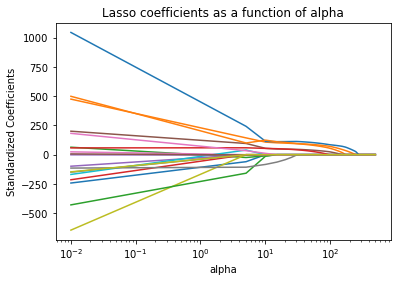

In [55]:
ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Standardized Coefficients')
plt.title('Lasso coefficients as a function of alpha');

- Remember that if alpha = 0, then the lasso gives the least squares fit, and when alpha becomes very large, the lasso gives the null model in which all coefficient estimates equal zero. 

- Moving from left to right in our plot, we observe that at first the lasso models contains many predictors with high magnitudes of coefficient estimates. With increasing alpha, the coefficient estimates approximate towards zero.

- Next, we use cross-validation to find the best value for alpha.

## Lasso with optimal alpha

- To find the optimal value of alpha, we use scikit learns lasso linear model with iterative fitting along a regularization path ([LassoCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html)). 

- The best model is selected by cross-validation.

### k-fold cross validation

In [58]:
from sklearn.linear_model import LassoCV

# Lasso with 5 fold cross-validation
model = LassoCV(cv=5, random_state=0, max_iter=10000)

# Fit model
model.fit(X_train, y_train)

LassoCV(cv=5, max_iter=10000, random_state=0)

Show best value of penalization chosen by cross validation:

In [59]:
model.alpha_

2.415116033844777

### Best model

Use best value for our final model:

In [60]:
# Set best alpha
lasso_best = Lasso(alpha=model.alpha_)

lasso_best.fit(X_train, y_train)

Lasso(alpha=2.415116033844777)

Show model coefficients and names:

In [61]:
print(list(zip(lasso_best.coef_, X)))

[(-174.84479794331742, 'AtBat'), (269.8647248906301, 'Hits'), (-14.435960681127156, 'HmRun'), (-46.7092161696163, 'Runs'), (-12.714234364761097, 'RBI'), (141.37329477067027, 'Walks'), (-10.18676339281558, 'Years'), (-0.0, 'CAtBat'), (0.0, 'CHits'), (75.20134267683102, 'CHmRun'), (344.21141739081617, 'CRuns'), (59.38092401270545, 'CRBI'), (-251.1390987161936, 'CWalks'), (61.72897563506071, 'PutOuts'), (-0.0, 'Assists'), (-1.4327410565952878, 'Errors'), (97.79377016720615, 'League_N'), (-116.67972363112084, 'Division_W'), (-67.49102750688394, 'NewLeague_N')]


### Model evaluation

In [62]:
# Show score

print('R squared training set', round(lasso_best.score(X_train, y_train)*100, 2))
print('R squared test set', round(lasso_best.score(X_test, y_test)*100, 2))

R squared training set 59.13
R squared test set 35.51


In [63]:
mean_squared_error(y_test, lasso_best.predict(X_test))

129404.30779952875

Lasso path: plot results of cross-validation with mean squared erros (for more information about the plot visit the [scikit-learn documentation](https://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_model_selection.html#sphx-glr-auto-examples-linear-model-plot-lasso-model-selection-py))

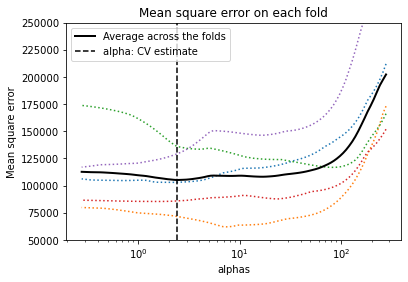

In [64]:
plt.semilogx(model.alphas_, model.mse_path_, ":")

plt.plot(
    model.alphas_ ,
    model.mse_path_.mean(axis=-1),
    "k",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(
    model.alpha_, linestyle="--", color="k", label="alpha: CV estimate"
)

plt.legend()
plt.xlabel("alphas")
plt.ylabel("Mean square error")
plt.title("Mean square error on each fold")
plt.axis("tight")

ymin, ymax = 50000, 250000
plt.ylim(ymin, ymax);